In [83]:
import numpy as np
import pandas as pd

In [84]:
data = pd.read_csv('../data/large_skill_injector_domain.csv')

In [85]:
data.head()

,average,date,highest,lowest,order_count,volume
0,797900000.0,2022-07-01,804300000,793000000.0,182,217
1,797700000.0,2022-07-02,805450000,790000000.0,110,139
2,809600000.0,2022-07-03,818750000,800500000.0,98,110
3,824200000.0,2022-07-04,825000000,819200000.0,103,127
4,829700000.0,2022-07-05,833500000,826500000.0,103,132


In [86]:
# Change the index to the date column since we are doing time series predictions
data = data.set_index('date')


<Axes: xlabel='date'>

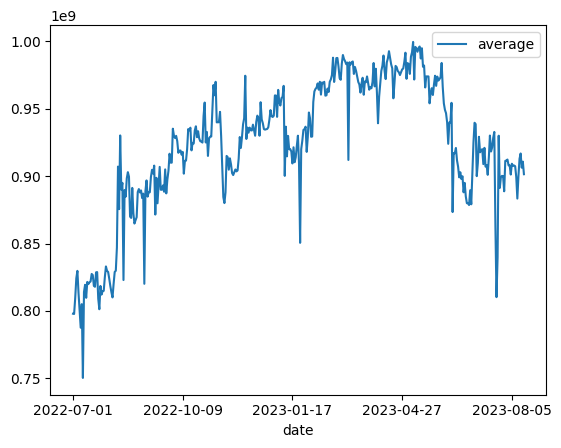

In [87]:
# Plot out each of our values to try and find a stable one to predict decided on average
data.plot.line(y="average", use_index=True)
# data.plot.line(y="lowest", use_index=True)
# data.plot.line(y="highest", use_index=True)

In [88]:
# Create our tomrrow column from our historic data
data["tomorrow"] = data["average"].shift(-1)

In [89]:
# Create our target column for our ML that just determines if the average will increase or decrease
data["target"] = data["tomorrow"]
data.loc[data["tomorrow"] > data["average"], "movement"] = 1
data.loc[data["tomorrow"] < data["average"], "movement"] = -1

In [90]:
horizons = [2,7,14]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()

    ratio_column = f"close_ratio_{horizon}"
    data[ratio_column] = data['average'] / rolling_averages['average']

    trend_column = f"trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["movement"]

    new_predictors += [ratio_column, trend_column]


data = data.dropna()

In [91]:
# Default model
from sklearn.linear_model import LinearRegression

In [92]:
model = LinearRegression()

train = data.iloc[:-100]
test = data.iloc[-100:]

predictors = ["average", "highest", "lowest", "order_count", "volume", "close_ratio_2",	"trend_2", "close_ratio_7",	"trend_7",	"close_ratio_14",	"trend_14"]
model.fit(train[predictors], train["target"])

LinearRegression()

In [93]:
y_pred = model.predict(test[predictors])
y_test = test["target"]

In [94]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print(r2)


0.7919563523196229


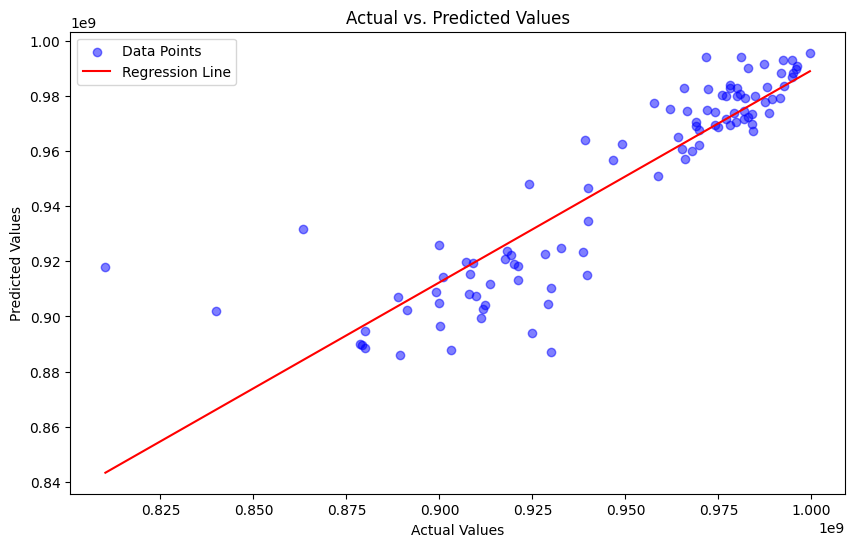

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set the figure size

plt.scatter(y_test, y_pred, color='blue', alpha=0.5)  # Create the scatter 
plt.title('Actual vs. Predicted Values')  # Set the title
plt.xlabel('Actual Values')  # Label the x-axis
plt.ylabel('Predicted Values')  # Label the y-axis

# Add a regression line
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')
plt.legend(['Data Points', 'Regression Line'])

plt.show()  # Display the plot
